In [1]:
# %load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import subprocess
import torch.nn.functional as F
import numpy as np
import pandas as pd
import esm
import biotite.structure.io as bsio
from pathlib import Path
import Bio.PDB as bp

def calculate_tm_score(
    pred_path, pdb_path, chain_id=None, use_tmalign=False, verbose=False,
    tmscore_path="/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign",
    tmalign_path="/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign.cpp"
):

    if chain_id is not None:
        raise NotImplementedError("Chain ID is not implemented for TM-score calculation.")

    # Run TMscore and capture the output
    command = [tmalign_path, pdb_path, pred_path] if use_tmalign else [tmscore_path, pred_path, pdb_path]
    result = subprocess.run(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    def print_cmd():
        print("TMscore command:")
        print(result.args)
        print("TMscore output:")
        print(result.stdout)
        print("TMscore error:")
        print(result.stderr)
    if verbose:
        print_cmd()

    # Extract TM-score from the output
    for line in result.stdout.split('\n'):
        if line.startswith("TM-score"):
            tm_score = float(line.split('=')[1].split()[0])
            return tm_score

    print_cmd()
    raise ValueError("TM-score not found in the output")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# !pip install autotime

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: False


In [4]:
from pathlib import Path
import os
import warnings
import pandas as pd
import tqdm
from Bio.PDB import PDBParser

import esm
import biotite.structure.io as bsio

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10000)
pd.set_option("max_colwidth", 100)
base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures")
SABDAB_SUMMARY_PATH = base_path / Path("sabdab_summary_after_80.tsv")
OUTPUT_PATH = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("raw")
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/lightning_lite/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/sabdab_summary_after_80.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/raw
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures


In [5]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df.head(5)

Entries in summary: 177


,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,organism,heavy_species,light_species,antigen_species,authors,resolution,method,r_free,r_factor,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,seqH,seqL,full_sequence,pLDDT_before,tm_score_before,Hchain_pLDDT_before,Hchain_tm_score_before,Lchain_pLDDT_before,Lchain_tm_score_before,Hchain_pLDDT_after,Hchain_tm_score_after,Lchain_pLDDT_after,Lchain_tm_score_after
0,9fyt,I,M,0,B,protein,NaN,alpha-cobratoxin,TOXIN,07/16/25,mAbs in complex with cobratoxin at pH 4.5,Homo sapiens; Naja kaouthia,homo sapiens,homo sapiens,naja kaouthia,"Wade, J., Bohn, M.F., Laustsen, A.H., Morth, J.P.",1.55,X-RAY DIFFRACTION,0.237,0.186,False,True,IGHV1,IGLV3,Lambda,NaN,NaN,NaN,NaN,NaN,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,SSYELTQPPSVSVAPGRTATITCEGDNIGQQIVHWYQQKPGQAPVAVISSDSDRPSGIPERFSGSNSGNTATLTISRVEAGDEADYYCQVWDSGSD...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,78.051160,NaN,78.051160,0.26598,78.051160,NaN,79.375530,0.26729,87.516016,0.2284
1,9lux,A,a,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,76.059034,NaN,76.059034,0.43121,76.059034,NaN,78.084864,0.43109,NaN,NaN
2,9lux,B,b,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,76.059034,NaN,76.059034,0.43121,76.059034,NaN,78.280960,0.43079,NaN,NaN
3,9lux,C,c,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,70.152480,NaN,70.152480,0.47795,70.152480,NaN,76.726656,0.47651,NaN,NaN
4,9lux,D,d,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,06/11/25,Single-chain Fv antibody of G2 fused with antigen peptide from chicken prion protein,Gallus gallus; Mus musculus,"gallus gallus, mus musculus",NaN,NaN,"Hanazono, Y., Yabuno, S., Hayashi, T., Numoto, N., Ito, N., Oda, M.",1.85,X-RAY DIFFRACTION,0.226,0.194,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,NaN,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,70.152480,NaN,70.152480,0.47795,70.152480,NaN,76.489022,0.46957,NaN,NaN


In [1]:
from proteinttt.utils.parsers import fetch_and_parse_sequences

In [ ]:
# df_with_seq = fetch_and_parse_sequences(df, PDB_FILES_PATH)
# df = df_with_seq.copy()
# df.to_csv(path_or_buf=base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

Using cuda


In [14]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PATH):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    out_path = out_dir / f"{pdb_id.lower()}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = struct.b_factor.mean()
    tm_score = calculate_tm_score(
        pred_path=out_path,
        pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    return pLDDT, tm_score

In [15]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PATH):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    model.ttt(sequence)
    pLDDT_after, tm_score_after = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after, tm_score_after

## Before

In [55]:
df.head(5)

,pdb,chain,chain_type,sequence,resolution
0,9fyt,B,antigen_chain,IRCFITPDITSKDCPNGHVCYTKTWCDAFCSIRGKRVDLGCAATCPTVKTGVDIQCCSTDNCNPFPTRKRP,1.55
1,9fyt,I,Hchain,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELRSLRSDDTAVYYC...,1.55
2,9fyt,M,Lchain,SSYELTQPPSVSVAPGRTATITCEGDNIGQQIVHWYQQKPGQAPVAVISSDSDRPSGIPERFSGSNSGNTATLTISRVEAGDEADYYCQVWDSGSD...,1.55
3,9lux,A,Hchain,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,1.85
4,9lux,B,Hchain,GEAVAAANQTEVEMENKVVLEVLFQGPDIVLTQSPASLAVSLGQRATISCKASQTLDYDGGTYMNWYQQKPGQPPKLLIFAASNLESGIPARFSGS...,1.85


In [ ]:
num_of_low = 0
col = 'sequence'

In [ ]:
for i, row in df.iterrows():
    if pd.notna(row.get("pLDDT_before")) :
        continue
    if pd.isna(row[col]):
        continue
    
    pdb_id = str(row.get("pdb"))
    tag = row.get("chain_type", "unknown")
    
    seq = str(row[col]).strip().upper()
    tag_chain = f'{tag}_{row["chain"]}'
    
    try:
        pLDDT_before, tm_score_before = predict_structure(model, seq, pdb_id, tag=f'{tag_chain}_before_ttt', out_dir=OUTPUT_PATH)
        df.at[i, f'pLDDT_before'] = pLDDT_before
        df.at[i, f'tm_score_before'] = tm_score_before
        if pLDDT_before < 70:
            num_of_low+=1
            print(num_of_low)
            df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag_chain}: {e}")
            
df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

28it [01:02,  1.60s/it]

## After

In [ ]:
c =0 
for i, row in df.iterrows():
    if len(str(row[col]).strip().upper()) > 500:
        continue
    c+=1
    pdb_id = str(row.get("pdb"))

    if pd.isna(row[col]):
        continue
    
    tag = row.get("chain_type", "unknown")
    seq = str(row[col]).strip().upper()
    tag_chain = f'{tag}_{row["chain"]}'

    try:
        pLDDT_after, tm_score_after = fold_chain(seq, pdb_id, model=model, tag=tag)
        df.at[i, 'pLDDT_after'] = pLDDT_after
        df.at[i, 'tm_score_after'] = tm_score_after
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag}: {e}")
    if c % 50 == 0:
        df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

## Plots

KeyError: 'pLDDT_after'

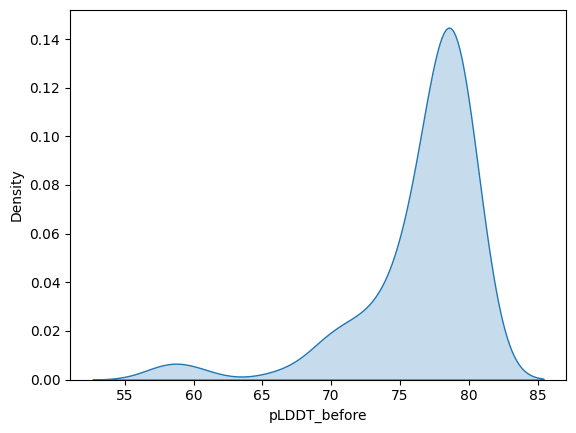

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.kdeplot(df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

In [18]:
sns.kdeplot(df['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(df['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

NameError: name 'sns' is not defined

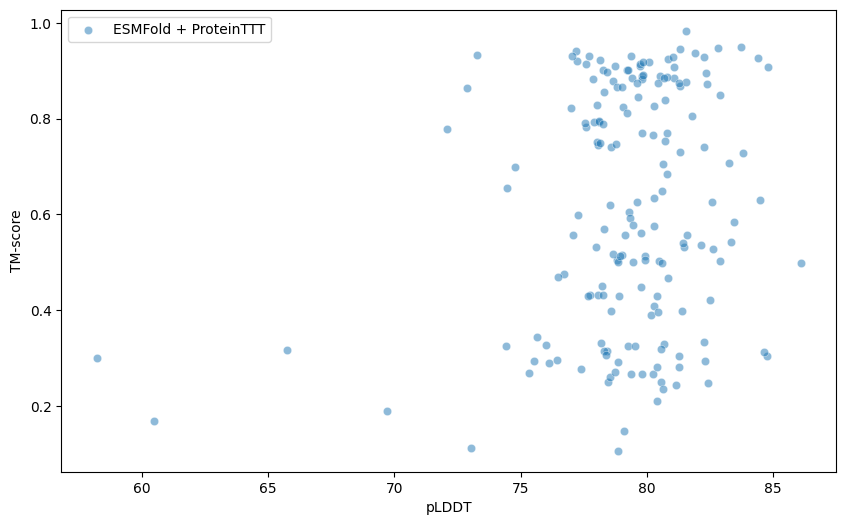

In [34]:
plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Hchain_pLDDT_before', y='Hchain_tm_score_before', data=df, label='ESMFold', alpha=0.5)
sns.scatterplot(x='Hchain_pLDDT_after', y='Hchain_tm_score_after', data=df, label='ESMFold + ProteinTTT', alpha=0.5)
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

In [30]:
rows = df.dropna(subset=['Hchain_pLDDT_before', 'Hchain_tm_score_before'])

In [32]:
from scipy.stats import pearsonr
pearsonr(rows['Hchain_pLDDT_after'], rows['Hchain_tm_score_after'])

PearsonRResult(statistic=0.21238543787315534, pvalue=0.004656368576873335)

Text(0, 0.5, 'TM-score difference after and before ProteinTTT')

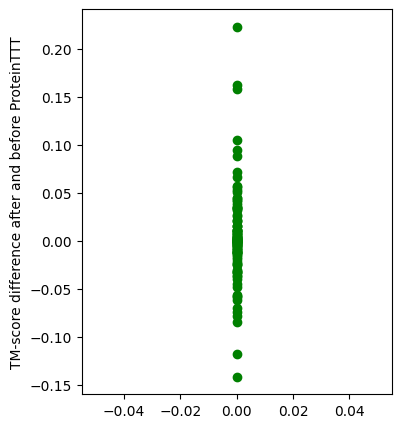

In [ ]:
df['Hchain_tm_score_diff'] = df['Hchain_tm_score_after'] - df['Hchain_tm_score_before']
plt.figure(figsize=(4, 5))
plt.scatter(np.zeros_like(df['Hchain_tm_score_diff']), df['Hchain_tm_score_diff'], color='green')
plt.ylabel('TM-score difference after and before ProteinTTT')

In [6]:
df_70 = pd.read_csv(base_path / "sabdab_summary_70.tsv", sep="\t", low_memory=False)

In [ ]:
df_70['diff'] = df_70['Hchain_tm_score_after'] - df_70['Hchain_tm_score_before']
top_10_diff = df_70.nlargest(10, 'diff')
print(top_10_diff[['pdb', 'Hchain', 'diff']])

      pdb Hchain     diff
62   7rug      L  0.22342
48   8k2w      N  0.16257
13   6hkg      C  0.15824
100  7kzb      A  0.10518
7    6y1r      B  0.09506
90   7nvo      N  0.08866
101  7d3m      H  0.07163
75   8ddk      A  0.06646
83   5cus      K  0.05765
69   8d0a      H  0.05618


## CDR pLDDT

In [ ]:
import re
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
from Bio.PDB import PDBParser


def extract_cdr_plddt_from_pdb(pdb_file_path, is_heavy: bool = True):
    """
    Extract pLDDT scores for CDR regions from a PDB file.
    Returns:
        Dict[str, Dict[str, float]]: Nested dictionary with structure:
        {
            'pair_1': {'H1': 85.2, 'H2': 90.1, 'H3': 78.5, 'L1': 88.3, 'L2': 92.1, 'L3': 82.7, 'CDR_mean': 86.2},
            'pair_2': {...},
            'overall': {'CDR_mean': 84.5}
        }
    """
    # CDR ranges based on Chothia numbering
    if is_heavy:
        CDR_RANGES = {
            'H1': (26, 32),
            'H2': (52, 56),
            'H3': (95, 102),
        }
    else: 
        CDR_RANGES = {
            'L1': (24, 34),
            'L2': (50, 56),
            'L3': (89, 97)
        }
        
        
    def is_in_cdr_region(residue_number: int):
        """Check if residue is in CDR region and return CDR name."""
        for cdr_name, (start, end) in CDR_RANGES.items():
            if start <= residue_number <= end:
                return cdr_name
        return None

    def extract_plddt_from_atoms(pdb_file_path):
        """Extract pLDDT values from B-factor column of ATOM records."""
        plddt_map = defaultdict(dict)

        with open(pdb_file_path, 'r') as f:
            for line in f:
                if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                    chain_id = line[21].strip()
                    residue_num_str = line[22:26].strip()
                    b_factor = float(line[60:66].strip())

                    try:
                        if residue_num_str[-1].isalpha():
                            residue_num = int(residue_num_str[:-1])
                        else:
                            residue_num = int(residue_num_str)
                    except ValueError:
                        print(f"Skipping line due to ValueError: {line.strip()}")
                        continue

                    plddt_map[chain_id][residue_num] = b_factor

        return plddt_map

    plddt_map = extract_plddt_from_atoms(pdb_file_path)
    print(f"pLDDT scores {plddt_map}")

    results = {}
    all_cdr_scores = []
    

    cdr_scores = {cdr: [] for cdr in ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']}

    for residue_num, plddt_score in plddt_map['A'].items():
        cdr_region = is_in_cdr_region( residue_num)
        if cdr_region:
            cdr_scores[cdr_region].append(plddt_score)

    # Calculate mean pLDDT for each CDR
    pair_results = {}
    for cdr_name, scores in cdr_scores.items():
        if scores:
            mean_score = sum(scores) / len(scores)
            pair_results[cdr_name] = round(mean_score, 2)
            all_cdr_scores.extend(scores)
        else:
            pair_results[cdr_name] = None  # CDR not found or no pLDDT data

    # Calculate mean for this chain
    valid_scores = [score for score in pair_results.values() if score is not None]
    if valid_scores:
        pair_results['CDR_mean'] = round(sum(valid_scores) / len(valid_scores), 2)
    else:
        pair_results['CDR_mean'] = None

    results = pair_results

    return results

In [9]:
df_1 = df.head(1)

In [34]:
for i, row in df_1.iterrows():
    
    pdb_file_H = f"/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures/{row.pdb}_{row.Hchain}_before_ttt.pdb"
    pdb_file_L = f"/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures/{row.pdb}_{row.Lchain}_before_ttt.pdb"
    
    cdr_plddt = extract_cdr_plddt_from_pdb(pdb_file_H, is_heavy=True)

    print("CDR pLDDT Scores:")
    print("=" * 50)
    print(cdr_plddt)

pLDDT scores defaultdict(<class 'dict'>, {'A': {1: 81.6, 2: 84.79, 3: 90.87, 4: 92.27, 5: 94.2, 6: 94.91, 7: 93.0, 8: 91.07, 9: 91.4, 10: 91.79, 11: 93.72, 12: 92.83, 13: 92.36, 14: 91.77, 15: 90.86, 16: 92.39, 17: 93.65, 18: 94.8, 19: 95.37, 20: 95.36, 21: 95.08, 22: 94.39, 23: 93.75, 24: 91.47, 25: 89.03, 26: 80.48, 27: 75.65, 28: 80.16, 29: 80.08, 30: 76.78, 31: 76.14, 32: 79.95, 33: 81.44, 34: 85.55, 35: 85.91, 36: 89.74, 37: 88.71, 38: 90.65, 39: 91.35, 40: 89.72, 41: 89.27, 42: 87.31, 43: 85.84, 44: 82.5, 45: 84.97, 46: 85.48, 47: 85.67, 48: 87.36, 49: 85.59, 50: 84.7, 51: 84.24, 52: 80.18, 53: 79.11, 54: 75.27, 55: 76.57, 56: 74.47, 57: 77.68, 58: 81.45, 59: 80.12, 60: 83.32, 61: 82.65, 62: 82.24, 63: 82.81, 64: 85.4, 65: 85.22, 66: 87.69, 67: 91.18, 68: 91.5, 69: 92.79, 70: 91.16, 71: 91.79, 72: 90.2, 73: 90.36, 74: 87.03, 75: 88.6, 76: 90.43, 77: 91.42, 78: 92.77, 79: 92.61, 80: 94.35, 81: 94.34, 82: 95.13, 83: 94.07, 84: 92.72, 85: 91.45, 86: 92.7, 87: 91.19, 88: 90.48, 89: 9